<a href="https://colab.research.google.com/github/abhinav815garg/Inference-Engine/blob/main/model_textClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [ ]:
from datasets import load_dataset
emotion = load_dataset('emotion', trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
label_names = emotion["train"].features['label'].names
label_names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [ ]:
emotion.set_format(type="pandas")
train_df = emotion['train'][:]
valid_df = emotion['validation'][:]
test_df = emotion['test'][:]

In [ ]:
train_df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [ ]:
train_df = train_df.groupby('label').apply(lambda x: x.sample(500)).reset_index(drop=True)
valid_df = valid_df.groupby('label').apply(lambda x: x.sample(80)).reset_index(drop=True)
test_df = test_df.groupby('label').apply(lambda x: x.sample(60)).reset_index(drop=True)

In [ ]:
train_df['label'].value_counts()

label
0    500
1    500
2    500
3    500
4    500
5    500
Name: count, dtype: int64

In [ ]:
from transformers import BertTokenizer

In [ ]:
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
def encode(docs):
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

In [ ]:
import torch

In [ ]:
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([3000]), torch.Size([480]), torch.Size([360]))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
N_labels = len(train_df.label.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM, num_labels=N_labels, output_attentions=False, output_hidden_states=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
EPOCHS = 30
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*EPOCHS )

In [ ]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))

    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 1.7916883756505682 
30/30 val loss: 1.7548765420913697 
Epoch:  2


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 1.7287831369866715 
30/30 val loss: 1.669556450843811 
Epoch:  3


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 1.6105053107789222 
30/30 val loss: 1.5125441392262777 
Epoch:  4


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 1.4524877851313733 
30/30 val loss: 1.340465517838796 
Epoch:  5


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 1.2653502714126668 
30/30 val loss: 1.1710907498995462 
Epoch:  6


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 1.084429474904182 
30/30 val loss: 1.0337647636731466 
Epoch:  7


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.9449561812142109 
30/30 val loss: 0.9195198059082031 
Epoch:  8


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.8258874815829257 
30/30 val loss: 0.8272050807873408 
Epoch:  9


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.7343115521238205 
30/30 val loss: 0.743523849050204 
Epoch:  10


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.6339136870934609 
30/30 val loss: 0.6795311719179153 
Epoch:  11


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.5675857084545683 
30/30 val loss: 0.6242441217104594 
Epoch:  12


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.5061210848866625 
30/30 val loss: 0.5861038838823637 
Epoch:  13


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.44632797989439454 
30/30 val loss: 0.539985565841198 
Epoch:  14


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.40504270601779857 
30/30 val loss: 0.5121359318494797 
Epoch:  15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.36329255387821097 
30/30 val loss: 0.4866200948754946 
Epoch:  16


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.32886371642668194 
30/30 val loss: 0.46214132035772004 
Epoch:  17


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.29737115330360037 
30/30 val loss: 0.44330758477250737 
Epoch:  18


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.274987029664694 
30/30 val loss: 0.43461009711027143 
Epoch:  19


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.2589362576366105 
30/30 val loss: 0.4238344877958298 
Epoch:  20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.24627237663941182 
30/30 val loss: 0.4151008526484172 
Epoch:  21


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.2228669920103981 
30/30 val loss: 0.4048806798954805 
Epoch:  22


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.20461478223033408 
30/30 val loss: 0.3994060883919398 
Epoch:  23


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.20389337647468486 
30/30 val loss: 0.3969533142944177 
Epoch:  24


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.19195375488476552 
30/30 val loss: 0.3918310475846132 
Epoch:  25


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.17812492981790862 
30/30 val loss: 0.39011977476378285 
Epoch:  26


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.17812217494591753 
30/30 val loss: 0.389164012670517 
Epoch:  27


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.17052620470999402 
30/30 val loss: 0.3877811578412851 
Epoch:  28


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.17613847993631312 
30/30 val loss: 0.3874959770590067 
Epoch:  29


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.1648828936740756 
30/30 val loss: 0.3868083228667577 
Epoch:  30


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

188/188 train loss: 0.16499885888968377 
30/30 val loss: 0.3865037735551596 


In [ ]:
from matplotlib import pyplot as plt

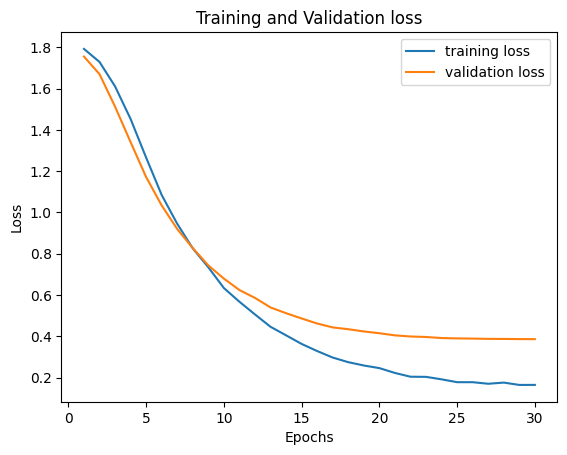

In [ ]:
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

(39, 3)


,text,label,pred
0,i woke up about am feeling a little disturbed,0,4
17,i have some great friends and great housemates...,0,1
39,i was studying i always had the feeling that t...,0,3
55,i cant helped but to feel burdened and anxious...,0,4
57,im okay with her getting married whirlwind sty...,0,3
59,i will nolonger tell anybody how i feel or wha...,0,3
62,i feel accepted and loved by a community of de...,1,2
69,i am alternating between feeling thrilled to s...,1,5
74,i have the joy of allowing kids to feel like t...,1,0
76,i feel like i know who most of them are by now...,1,2


In [ ]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=label_names))

classifiation report
              precision    recall  f1-score   support

     sadness       0.90      0.86      0.88        63
         joy       0.87      0.91      0.89        57
        love       0.87      0.91      0.89        57
       anger       0.93      0.90      0.92        62
        fear       0.85      0.91      0.88        56
    surprise       0.93      0.86      0.90        65

    accuracy                           0.89       360
   macro avg       0.89      0.89      0.89       360
weighted avg       0.89      0.89      0.89       360

